In [1]:
import glob, os, sys, vcf, subprocess
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended  

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"] = 150
import scipy.stats as st

from scipy.spatial.distance import pdist, squareform

# Compute genetic distance matrices

1. For all sequences
2. Between Bangladesh sequences only

In [4]:
# contains isolate MK575063, which has the premature stop codon
#P_seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse("seq_for_analysis/P_unique_HeV.fasta", "fasta")]
P_seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/genes/G_seqs.fasta", "fasta")]

P_seq_df = pd.DataFrame(P_seqs)
P_seq_df.columns = ["ID", "Seq"]

# remove Hendra virus sequence too
#P_seq_df = P_seq_df.loc[(~P_seq_df["Seq"].str.contains("N")) & (P_seq_df["ID"] != "JN255817")].reset_index(drop=True)
P_seq_df = P_seq_df.loc[(P_seq_df["ID"] != "JN255817")].reset_index(drop=True)

print(P_seq_df.shape)

lengths = [len(seq) for seq in P_seq_df["Seq"]]
print(np.unique(lengths))

metadata = pd.read_csv("metadata.csv")

for i, row in P_seq_df.loc[P_seq_df.Seq.str.contains("N")].iterrows():
    
    if len(np.where(np.array(list(row["Seq"]))=="N")[0]) / len(row["Seq"]) > 0.01:
        print(f"Removed {row['ID']}")
        P_seq_df = P_seq_df.drop(i)
        
print(P_seq_df.shape)

(84, 2)
[1809]
Removed JF899340
Removed MH891777
Removed MK673580
Removed MK673586
Removed MN549402
Removed MN549405
Removed MN549406
Removed MN549407
Removed MN549408
Removed MN549410
(74, 2)


In [5]:
seq_mat = P_seq_df["Seq"].str.split("", expand=True).iloc[:, 1:-1]
seq_mat.columns = np.arange(len(P_seq_df.Seq.values[0]))+1
seq_mat["ID"] = P_seq_df.ID
seq_mat = seq_mat.set_index("ID")

In [6]:
# no indels in these sequences, all are same length
NUM_TO_BASE = {0:"A", 1:"C", 2:"G", 3:"T", 4:"N"}
BASE_TO_NUM = {}

for key, val in NUM_TO_BASE.items():
    BASE_TO_NUM[val] = key

In [7]:
seq_mat = seq_mat.replace(BASE_TO_NUM)
similarity_mat = 1 - squareform(pdist(seq_mat, metric="hamming"))

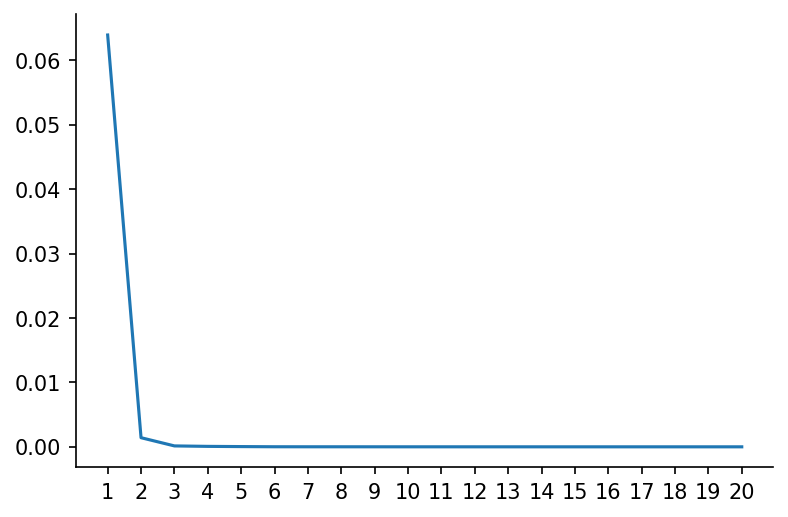

In [8]:
pca = PCA(20)
pca.fit(similarity_mat)

plt.plot(np.arange(20)+1, pca.explained_variance_)
sns.despine()
plt.xticks(np.arange(20)+1)
plt.show()

## Super tight clustering compared to distances between clusters

## Quantify that magnitude difference!!

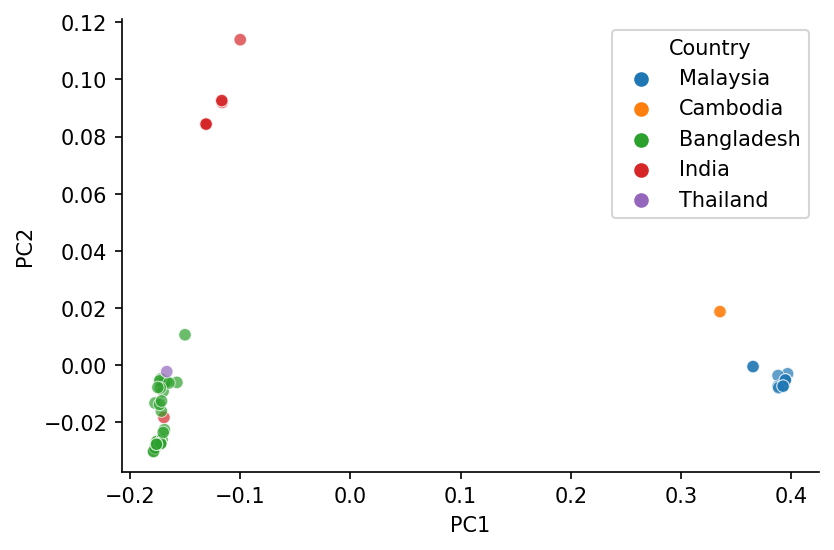

In [9]:
pca = PCA(2)
x_trans = pca.fit_transform(similarity_mat)

x_trans_df = pd.DataFrame(x_trans)
x_trans_df.columns = ["PC1", "PC2"]
x_trans_df["ID"] = seq_mat.index
x_trans_df = x_trans_df.merge(metadata, on="ID")

# the India sequence FJ513078 is in the Bangladesh cluster, just not visible, but checked the coordinates
sns.scatterplot(data=x_trans_df, x="PC1", y="PC2", hue="Country", alpha=0.7)
sns.despine()
plt.show()

In [10]:
similarity_mat.shape

(74, 74)

In [11]:
mys_mat = similarity_mat[x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index, :][:, x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index]
bgd_mat = similarity_mat[x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index, :][:, x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index]
india_mat = similarity_mat[x_trans_df.query("Country == 'India'").index, :][:, x_trans_df.query("Country == 'India'").index]

In [12]:
mys_vals = mys_mat[np.triu_indices(mys_mat.shape[0], k=1)]
india_vals = india_mat[np.triu_indices(india_mat.shape[0], k=1)]
bgd_vals = bgd_mat[np.triu_indices(bgd_mat.shape[0], k=1)]

df_sim_mat = pd.DataFrame({"Sim": np.concatenate([mys_vals, india_vals, bgd_vals]),
                           "Country": ["Malaysia"]*len(mys_vals) + ["India"]*len(india_vals) + ["Bangladesh"]*len(bgd_vals)
                          })

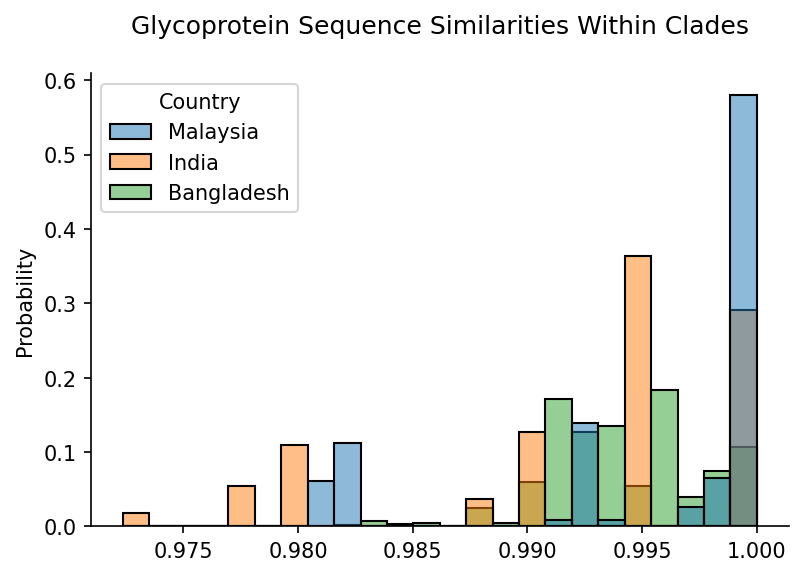

In [14]:
sns.histplot(data=df_sim_mat, x="Sim", hue="Country", common_norm=False, stat="probability", element="bars", kde=False,
            multiple="layer")

plt.title("Glycoprotein Sequence Similarities Within Clades\n")
plt.xlabel("")
sns.despine()
plt.show()

In [12]:
# fig, ax = plt.subplots()

# ax.scatter(y=3, x=np.mean(mys_vals), label="Malaysia")
# ax.errorbar(y=[3]*len(mys_vals), x=mys_vals)

# ax.scatter(y=2, x=np.mean(india_vals), label="India")
# ax.errorbar(y=[2]*len(india_vals), x=india_vals)

# ax.scatter(y=1, x=np.mean(bgd_vals), label="Bangladesh")
# ax.errorbar(y=[1]*len(bgd_vals), x=bgd_vals)

# sns.despine()
# plt.show()

In [15]:
between_clade_diffs = np.concatenate([
    #similarity_mat[:, x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index][x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index, :].flatten(),
                                      #similarity_mat[:, x_trans_df.query("Country in ['India']").index][x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index, :].flatten(),
                                      similarity_mat[:, x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index][x_trans_df.query("Country in ['India']").index, :].flatten()
                                    ])

between_clade_diffs.shape

(451,)

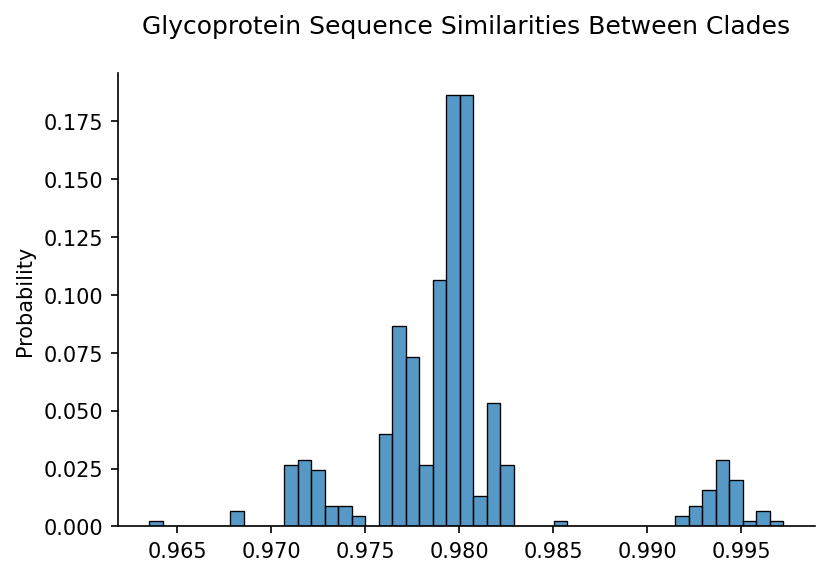

In [16]:
sns.histplot(between_clade_diffs, stat="probability")
sns.despine()
plt.title("Glycoprotein Sequence Similarities Between Clades\n")

plt.show()

In [17]:
# flattened array of the upper triangular values, excluding the diagonal (which are all 1s)
# if you change k to 0, the 1s come back, so k=1 is correct.
unique_dist = similarity_mat[np.triu_indices(similarity_mat.shape[0], k=1)]

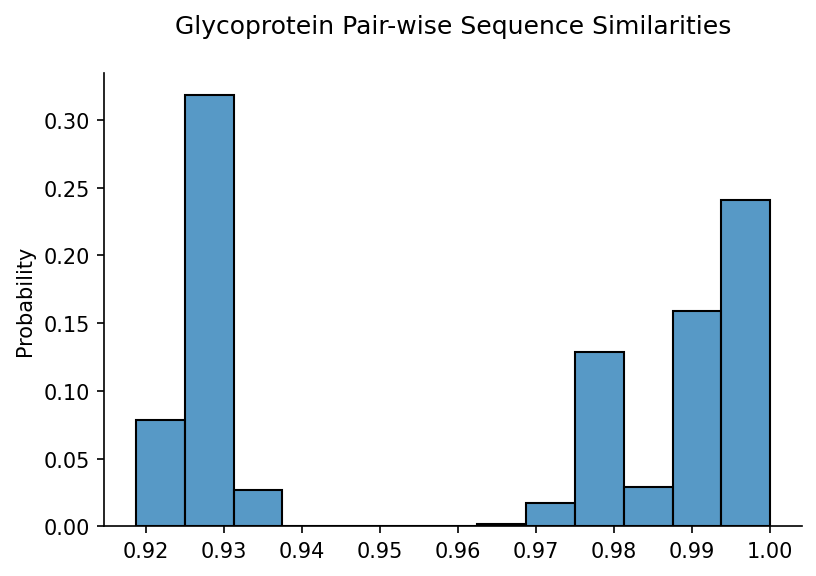

In [18]:
sns.histplot(unique_dist, stat="probability")
sns.despine()
plt.title("Glycoprotein Pair-wise Sequence Similarities\n")

plt.show()

# SNP Calling

## Can do manually because so few sequences, and the command line tools are better optimized for sequencing reads (i.e. fastq)

In [70]:
data_transf = P_seq_df.Seq.str.split("", expand=True).iloc[:, 1:-1].T.reset_index()
data_transf.columns = ["Pos"] + list(P_seq_df.ID.values)
data_transf = data_transf.set_index("Pos")

# add reference to the dataframe
mys_ref_P = [str(seq.seq) for seq in SeqIO.parse("sequences/genome/NC_00278_MYS_P.fasta", "fasta")][0]
data_transf["REF"] = list(mys_ref_P)

In [192]:
keep_rows = []

for i in range(len(data_transf)):
    if len(np.where(np.unique(data_transf.iloc[i, :]) != "N")[0]) > 1:
        keep_rows.append(i)
        
# get SNP dataframe with only positions where there are alternative alleles
snp_df = data_transf.iloc[np.array(keep_rows), :]

# make dataframe of just the reference sequence. Will make it easier to compare 2 dataframes
ref_df = pd.DataFrame(columns=snp_df.columns[:-1])

for col in ref_df.columns:
    ref_df[col] = snp_df["REF"].values
    
del snp_df["REF"]

ref_df.index = snp_df.index

# SNPs aligned to MYS reference. 1 indicates an alternative allele, 0 is reference
snp_df = (snp_df != ref_df).astype(int).T

In [109]:
# # same dictionaries as used above
# # no indels in these sequences, all are same length
# NUM_TO_BASE = {0:"A", 1:"C", 2:"G", 3:"T", 4:"N"}
# BASE_TO_NUM = {}

# for key, val in NUM_TO_BASE.items():
#     BASE_TO_NUM[val] = key
    
# # Get one hot vector
# def get_one_hot(sequence):

#     if not pd.isnull(sequence):
#         seq_in_index = np.array([BASE_TO_COLUMN.get(b, b) for b in sequence])

#         one_hot = np.zeros((len(sequence), 4))

#         # only get the non N sites because otherwise we get indexing errors
#         ind_non_gap = np.where(seq_in_index != 4)[0]

#         # Assign the found positions to 1
#         one_hot[ind_non_gap, seq_in_index[ind_non_gap]] = 1

#         # flatten the array
#         return one_hot.flatten()
#     else:
#         return np.nan
    
# P_seq_df["seq_one_hot"] = P_seq_df.Seq.apply(get_one_hot)

In [111]:
def plot_PCA(snp_matrix, color_col, n_comp=2):
    '''
    Perform PCA using the SNP matrix
    '''
    
    ncbi_ids = snp_matrix.index.values
    
    scaler = StandardScaler()
    X = scaler.fit_transform(snp_matrix.values)
    
    pca_10 = PCA(n_components=10)
    pca_10.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(1, 11), pca_10.explained_variance_ratio_)
    
    pca = PCA(n_components=n_comp)
    X_new = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_new).rename(columns=dict(zip(np.arange(n_comp), [f"PC{num}" for num in np.arange(n_comp)+1])))
    pca_df["ID"] = ncbi_ids
    
    sliced_metadata = metadata.loc[metadata.ID.isin(snp_matrix.index)]
    pca_df = pca_df.merge(sliced_metadata[["ID", "Country", "Clade"]], on="ID")
        
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=color_col, alpha=0.7, s=50, ax=ax[1])
    sns.despine()
    plt.show()
    
    return X, pca_df

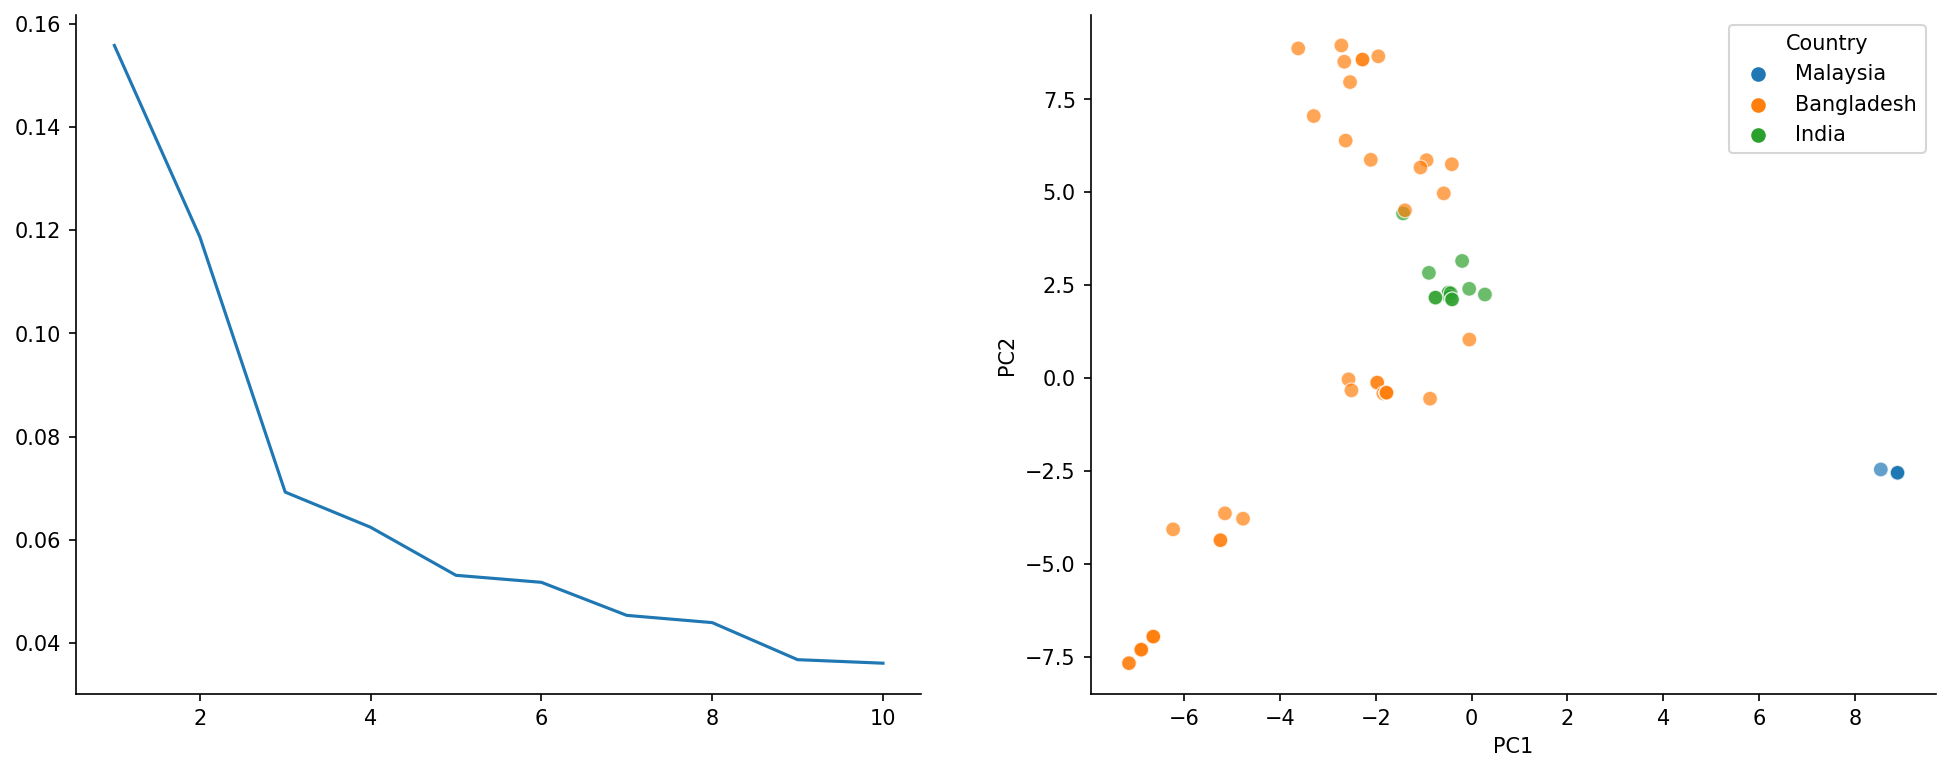

In [13]:
_, pca_df = plot_PCA(input_mat, "Country")

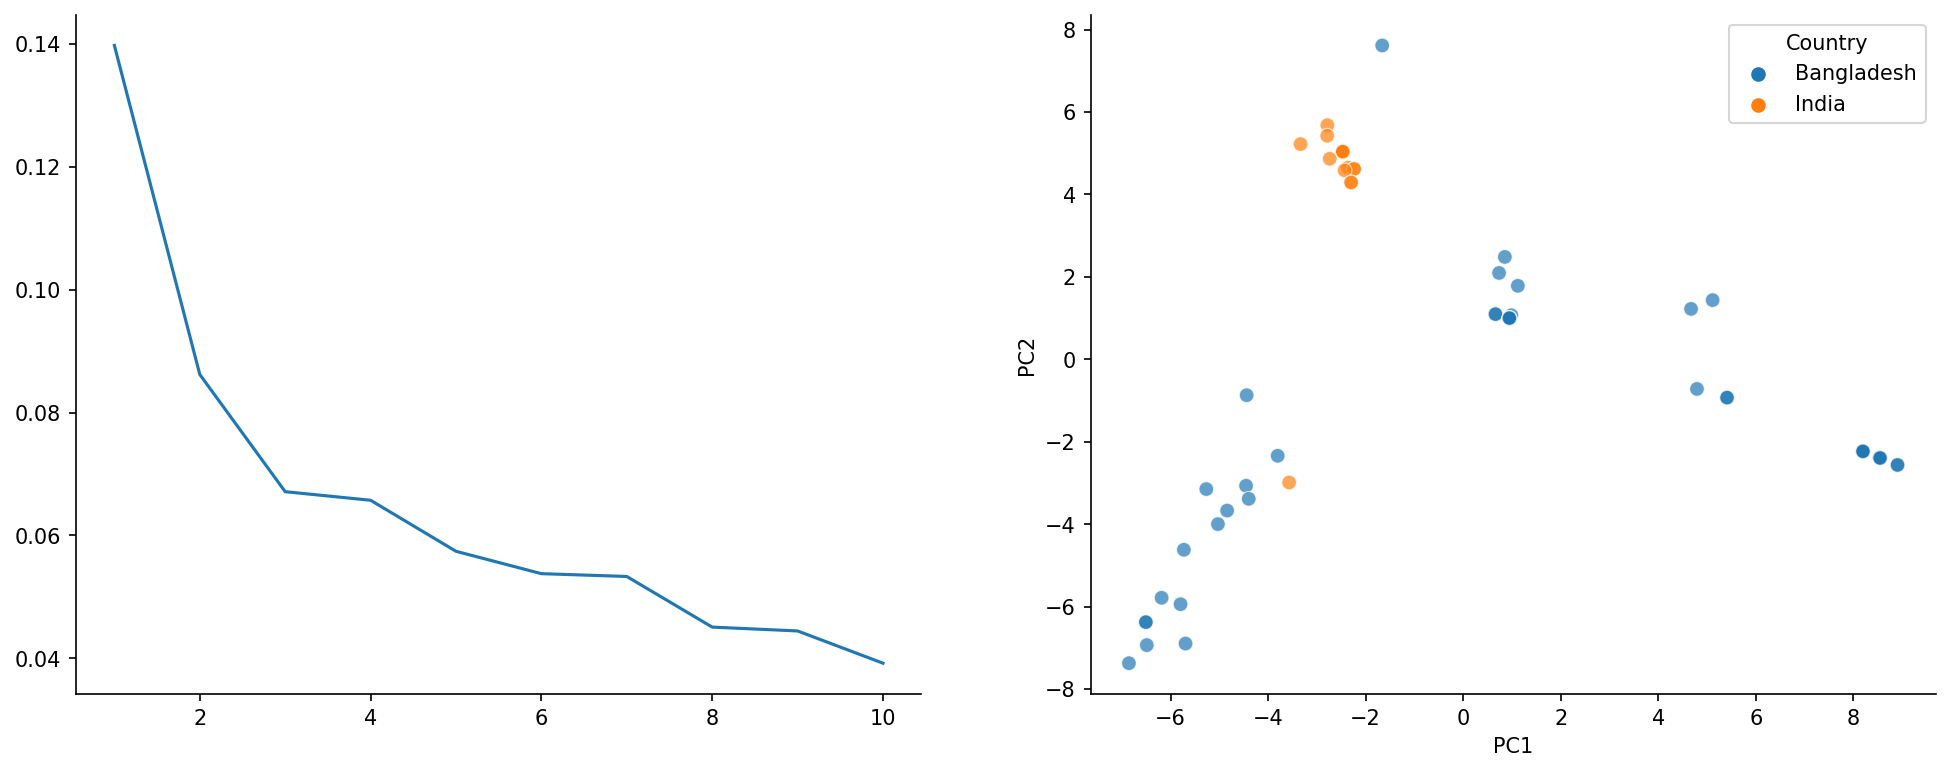

In [14]:
_, pca_df = plot_PCA(input_mat.loc[input_mat.index.isin(metadata.query("Country == 'Bangladesh' | Country == 'India'").ID)],
                     "Country", 2)

# Bootstrap enrichment of certain alleles at each site?

In [194]:
snp_df

Pos,21,88,96,99,120,122,132,138,141,145,...,2064,2070,2085,2088,2094,2097,2101,2112,2121,2124
AF212302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AF376747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AJ564621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AJ564622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AJ564623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MN549409,1,0,1,0,1,1,1,1,1,1,...,1,0,0,0,1,1,0,0,0,1
MN549410,1,0,1,0,1,1,1,1,1,1,...,1,0,0,0,1,1,0,0,0,1
MN549411,1,0,1,0,1,1,1,1,1,1,...,1,0,0,0,1,1,0,0,0,1
MW535746,1,0,1,0,1,1,1,1,0,0,...,1,1,1,0,1,1,0,0,0,1


In [229]:
sample_idx = np.random.choice(np.arange(len(snp_df)), size=len(snp_df), replace=True)

In [237]:
np.mean(snp_df.iloc[sample_idx, :][88].values - y[sample_idx])

-0.620253164556962

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [ ]:
sum()

In [172]:
sum(snp_df.T.iloc[0, :])

0

# L1/L2-Penalized Logistic Regression, Bangladesh vs. India

In [221]:
y = metadata.loc[metadata["ID"].str.contains("|".join(snp_df.index))].Country.replace({"Bangladesh": 1, "India": 1, "Thailand": 1, "Malaysia": 0, "Cambodia": 0}).values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(snp_df.values, y, stratify=y)
np.mean(y_train), np.mean(y_test)

(0.7457627118644068, 0.75)

In [222]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

logistic_cv = LogisticRegressionCV(Cs=np.logspace(-3, 3, 7), 
                                   fit_intercept=True, 
                                   cv=5, 
                                   penalty='elasticnet', 
                                   #scoring='precision_recall_fscore_support',
                                   #scoring='log_loss', # cross entropy function for crossentropy
                                   #scoring='f1_weighted',
                                   scoring="balanced_accuracy",
                                   solver='saga', 
                                   max_iter=10000, 
                                   class_weight='balanced', 
                                   l1_ratios=np.linspace(0, 1, 11),
                                  )

logistic_cv.fit(X_train, y_train)
l1_ratio = logistic_cv.l1_ratio_[0]
alpha = 1/logistic_cv.C_[0]
print(f"L1 ratio: {l1_ratio}, alpha = {alpha}")

L1 ratio: 0.0, alpha = 1000.0


In [223]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

Ridge(alpha=1000)

In [224]:
np.round(ridge.predict(X_test)).astype(int)

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [225]:
y_test.astype(int)

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [227]:
ridge_cv = LogisticRegressionCV(Cs=np.logspace(-5, 5, 21), 
                               fit_intercept=True, 
                               cv=5, 
                               penalty='l2', 
                               #scoring='precision_recall_fscore_support',
                               #scoring='log_loss', # cross entropy function for crossentropy
                               #scoring='f1_weighted',
                               scoring="balanced_accuracy",
                               solver='saga', 
                               max_iter=10000, 
                               class_weight='balanced', 
                                )

ridge_cv.fit(X_train, y_train)
print(f"C = {ridge_cv.C_[0]}")

C = 1e-05


array([[ 0.58387421, -0.13130643,  0.50529115, ..., -0.39605902,
        -0.13130643,  0.47871355],
       [ 0.58387421, -0.13130643,  0.50529115, ..., -0.39605902,
        -0.13130643,  0.47871355],
       [ 0.58387421, -0.13130643,  0.50529115, ..., -0.39605902,
        -0.13130643,  0.47871355],
       ...,
       [ 0.58387421, -0.13130643,  0.50529115, ...,  2.52487623,
        -0.13130643,  0.47871355],
       [ 0.58387421, -0.13130643,  0.50529115, ..., -0.39605902,
        -0.13130643,  0.47871355],
       [ 0.58387421, -0.13130643,  0.50529115, ..., -0.39605902,
        -0.13130643,  0.47871355]])

In [168]:
np.mean(X_train)

-5.5690622965423745e-18

In [169]:
np.std(X_train)

0.9736410419722029

In [162]:
model = LogisticRegression(penalty='l2', 
                           C=logistic_cv.C_[0]
                           class_weight='balanced',
                           solver='liblinear',
                           max_iter=10000
                  )

model.fit(X_train, y_train)

SyntaxError: invalid syntax (619367331.py, line 3)

In [160]:
model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1])